In [2]:
!pip install tensorflow

In [9]:
!pip install matplotlib
!pip install numpy

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/59/e2/6b155713e8da8274367b41315b66260f9d3c52d9f4b26336ddc3986ba612/matplotlib-3.8.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/ca/2a/d197a412ec474391ee878b1218cf2fe9c6e963903755887fc5654c06636a/contourpy-1.2.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/a0/90/e58e06130ffaf7859959a128fe11ad6533d3e5f4ecf65ecba7464981afdd/fonttools-4.44.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/156.8 kB ? eta -:--:--
     ------- ----------------------------- 30.7/156.8 kB 640.0 kB/s e

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [15]:
import pathlib

data_dir = r'C:\Users\Calvin Tran\Documents\School\Capstone\tomato_disease_data\all'

In [16]:
batch_size = 32
img_height = 180
img_width = 180

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11100 files belonging to 10 classes.
Using 8880 files for training.
Found 11100 files belonging to 10 classes.
Using 2220 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_mosaic_virus', 'Yellow_Leaf_Curl_Virus', 'healthy']


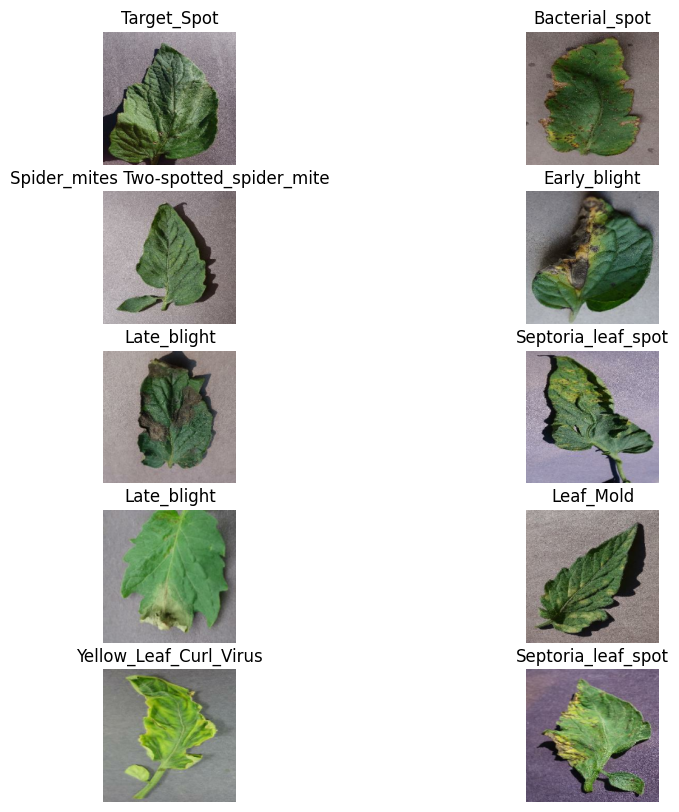

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(5,2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

# Cache the data and prefetch (to allow concurrency between data preprocessing and model execution)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
# Rescaling the RGB values from [0,255] to [0,1]. One approach is to apply this layer directly to the dataset, like so:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

# Or we can apply it directly to the model, as we see below.

0.0 1.0


In [27]:
num_classes = len(class_names)

# Create model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [29]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
278/278 [==============================] - 73s 232ms/step - loss: 1.1638 - accuracy: 0.5920 - val_loss: 0.6702 - val_accuracy: 0.7640
Epoch 2/10
278/278 [==============================] - 67s 239ms/step - loss: 0.5730 - accuracy: 0.8062 - val_loss: 0.4724 - val_accuracy: 0.8396
Epoch 3/10
278/278 [==============================] - 66s 238ms/step - loss: 0.4001 - accuracy: 0.8700 - val_loss: 0.5924 - val_accuracy: 0.8054
Epoch 4/10
278/278 [==============================] - 62s 224ms/step - loss: 0.3040 - accuracy: 0.8994 - val_loss: 0.4000 - val_accuracy: 0.8779
Epoch 5/10
278/278 [==============================] - 63s 228ms/step - loss: 0.2068 - accuracy: 0.9307 - val_loss: 0.5168 - val_accuracy: 0.8383
Epoch 6/10
278/278 [==============================] - 74s 268ms/step - loss: 0.1602 - accuracy: 0.9477 - val_loss: 0.5125 - val_accuracy: 0.8495
Epoch 7/10
278/278 [==============================] - 73s 264ms/step - loss: 0.1248 - accuracy: 0.9593 - val_loss: 0.6412 - val_ac

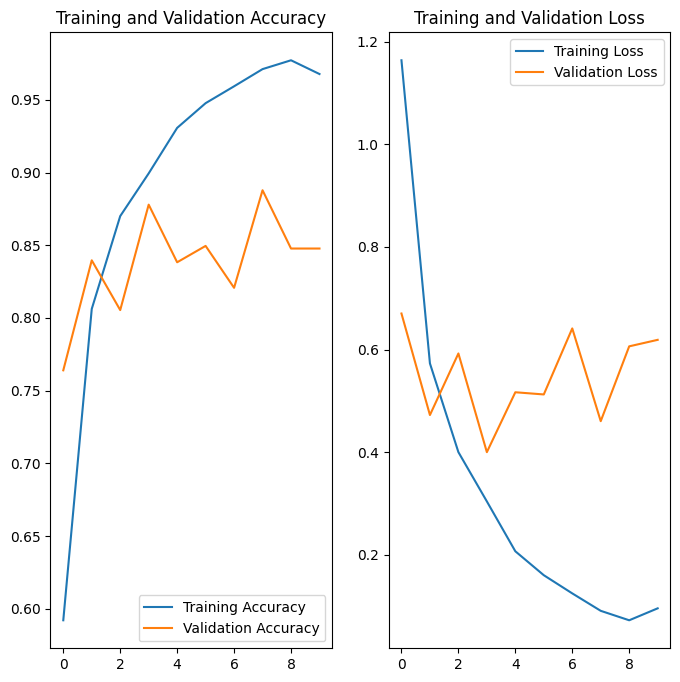

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

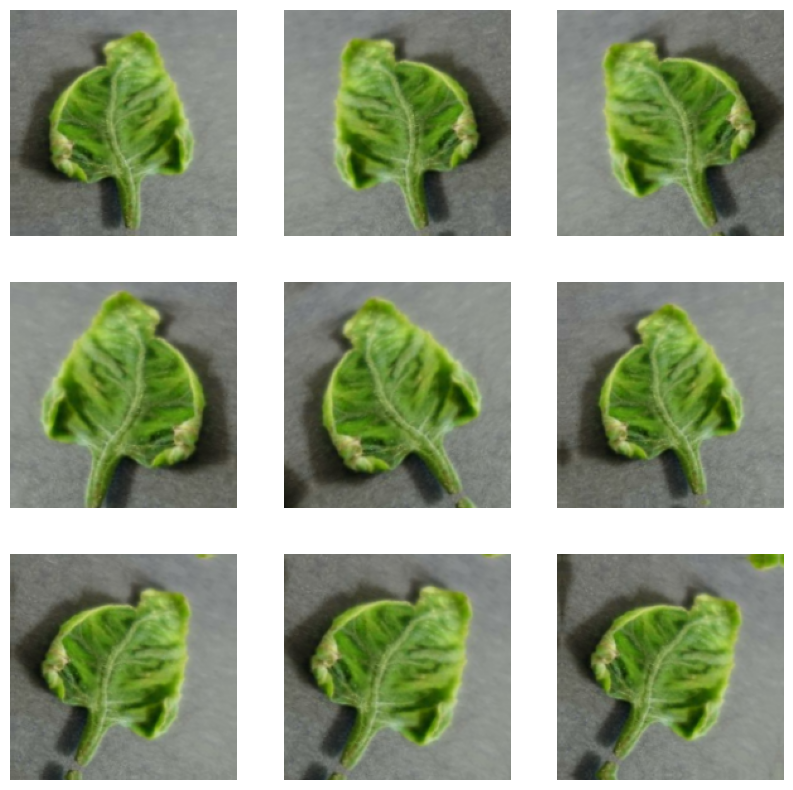

In [31]:
# Clearly, we see overfitting occurring, due to the increase in training accuracy but lack of increase in validation acccuracy.
# Augment the data to help the model generalize better

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [32]:
# Implement the model again, but this time with augmentation and dropout

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [34]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
278/278 [==============================] - 140s 495ms/step - loss: 1.3595 - accuracy: 0.5251 - val_loss: 0.8797 - val_accuracy: 0.7113
Epoch 2/15
278/278 [==============================] - 127s 458ms/step - loss: 0.6785 - accuracy: 0.7678 - val_loss: 0.7676 - val_accuracy: 0.7559
Epoch 3/15
278/278 [==============================] - 94s 337ms/step - loss: 0.5325 - accuracy: 0.8215 - val_loss: 0.6335 - val_accuracy: 0.8086
Epoch 4/15
278/278 [==============================] - 70s 252ms/step - loss: 0.4589 - accuracy: 0.8488 - val_loss: 0.6054 - val_accuracy: 0.8023
Epoch 5/15
278/278 [==============================] - 70s 251ms/step - loss: 0.3818 - accuracy: 0.8721 - val_loss: 0.5893 - val_accuracy: 0.8329
Epoch 6/15
278/278 [==============================] - 71s 254ms/step - loss: 0.3905 - accuracy: 0.8677 - val_loss: 0.4247 - val_accuracy: 0.8712
Epoch 7/15
278/278 [==============================] - 70s 253ms/step - loss: 0.3156 - accuracy: 0.8953 - val_loss: 0.5353 - val_

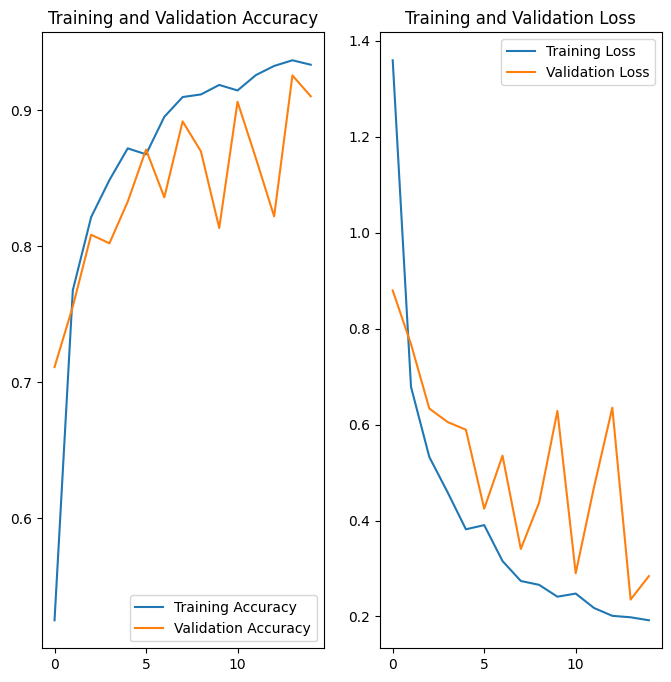

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()